# Imports

In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Normalization, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [4]:
df = pd.read_csv('Clean_Dataset.csv')

df = df.drop(['Unnamed: 0', 'flight'], axis=1)
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [31]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs. Predicted Prices")
    plt.grid(True)

    # Add the y=x line
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)

    plt.show()

# Data Manipulation

In [6]:
def convertStops(stops):
    if stops=='zero':
        return 0
    elif stops=='one':
        return 1
    else:
        return 2

In [7]:
df['stops_mapped'] = df['stops'].apply(convertStops)
df.drop('stops', axis=1, inplace=True)
df.sample(5)

,airline,source_city,departure_time,arrival_time,destination_city,class,duration,days_left,price,stops_mapped
140294,AirAsia,Kolkata,Evening,Morning,Bangalore,Economy,14.67,35,3862,1
28855,Air_India,Delhi,Morning,Morning,Hyderabad,Economy,2.33,2,5955,0
122422,Vistara,Kolkata,Morning,Afternoon,Delhi,Economy,2.33,20,4001,0
152090,Indigo,Kolkata,Night,Early_Morning,Chennai,Economy,8.00,44,3015,1
81015,Air_India,Mumbai,Night,Afternoon,Chennai,Economy,15.17,28,4417,1


In [8]:
df['stops_mapped'].corr(df['price'])

np.float64(0.1196484707241398)

In [9]:
df.groupby('airline')['price'].mean()

airline
AirAsia       4091.072742
Air_India    23507.019112
GO_FIRST      5652.007595
Indigo        5324.216303
SpiceJet      6179.278881
Vistara      30396.536302
Name: price, dtype: float64

In [10]:
airline_map = {'AirAsia':0, 'Indigo':1, 'GO_FIRST':2, 'SpiceJet':3, 'Air_India':4, 'Vistara':5}
df['airline_mapped'] = df['airline'].map(airline_map)
df.drop('airline', axis=1, inplace=True)
df.sample(5)

,source_city,departure_time,arrival_time,destination_city,class,duration,days_left,price,stops_mapped,airline_mapped
64128,Mumbai,Afternoon,Afternoon,Kolkata,Economy,25.33,16,14348,1,3
293053,Chennai,Morning,Evening,Mumbai,Business,6.92,43,61873,1,5
20365,Delhi,Evening,Early_Morning,Kolkata,Economy,11.83,3,5954,1,2
179866,Hyderabad,Morning,Evening,Chennai,Economy,7.67,42,4229,1,4
36857,Delhi,Afternoon,Night,Chennai,Economy,8.25,13,7950,1,1


In [11]:
df['route'] = df['source_city'] + '-' + df['destination_city']
df.groupby('route')['price'].mean()

route
Bangalore-Chennai      23321.850078
Bangalore-Delhi        17723.313972
Bangalore-Hyderabad    21226.121192
Bangalore-Kolkata      23500.061229
Bangalore-Mumbai       23128.618672
Chennai-Bangalore      25081.850454
Chennai-Delhi          18981.863948
Chennai-Hyderabad      21591.345404
Chennai-Kolkata        22669.932407
Chennai-Mumbai         22765.849647
Delhi-Bangalore        17880.216315
Delhi-Chennai          19369.881354
Delhi-Hyderabad        17347.288379
Delhi-Kolkata          20566.409418
Delhi-Mumbai           19355.829812
Hyderabad-Bangalore    21347.177998
Hyderabad-Chennai      21848.065989
Hyderabad-Delhi        17243.945685
Hyderabad-Kolkata      20823.893201
Hyderabad-Mumbai       20080.865759
Kolkata-Bangalore      22744.808428
Kolkata-Chennai        23660.361040
Kolkata-Delhi          19422.354559
Kolkata-Hyderabad      21500.011397
Kolkata-Mumbai         22078.883579
Mumbai-Bangalore       23147.873807
Mumbai-Chennai         22781.899112
Mumbai-Delhi          

In [12]:
# Calculate the mean price for each route
mean_price_by_route = df.groupby('route')['price'].mean()

# Sort the routes by their mean price
ranked_routes = mean_price_by_route.sort_values(ascending=True)

# Create a dictionary mapping each route to its rank (0-based)
route_rank_dict = {route: rank for rank, route in enumerate(ranked_routes.index)}

# Display the dictionary
print(route_rank_dict)

{'Hyderabad-Delhi': 0, 'Delhi-Hyderabad': 1, 'Bangalore-Delhi': 2, 'Delhi-Bangalore': 3, 'Mumbai-Delhi': 4, 'Chennai-Delhi': 5, 'Delhi-Mumbai': 6, 'Delhi-Chennai': 7, 'Kolkata-Delhi': 8, 'Hyderabad-Mumbai': 9, 'Delhi-Kolkata': 10, 'Hyderabad-Kolkata': 11, 'Mumbai-Hyderabad': 12, 'Bangalore-Hyderabad': 13, 'Hyderabad-Bangalore': 14, 'Kolkata-Hyderabad': 15, 'Chennai-Hyderabad': 16, 'Hyderabad-Chennai': 17, 'Kolkata-Mumbai': 18, 'Mumbai-Kolkata': 19, 'Chennai-Kolkata': 20, 'Kolkata-Bangalore': 21, 'Chennai-Mumbai': 22, 'Mumbai-Chennai': 23, 'Bangalore-Mumbai': 24, 'Mumbai-Bangalore': 25, 'Bangalore-Chennai': 26, 'Bangalore-Kolkata': 27, 'Kolkata-Chennai': 28, 'Chennai-Bangalore': 29}


In [13]:
df['route_mapped'] = df['route'].map(route_rank_dict)
df.drop(['route', 'source_city', 'destination_city'], axis=1, inplace=True)
df.sample(5)

,departure_time,arrival_time,class,duration,days_left,price,stops_mapped,airline_mapped,route_mapped
250217,Morning,Evening,Business,5.58,20,39623,1,4,24
198774,Afternoon,Night,Economy,9.83,12,12779,1,2,20
57753,Evening,Night,Economy,6.17,29,4644,1,1,25
122025,Evening,Night,Economy,28.00,17,7714,1,4,8
11130,Early_Morning,Afternoon,Economy,7.42,8,7423,1,0,3


In [14]:
df['route_mapped'].corr(df['price'])

np.float64(0.08943922270058315)

In [15]:
class_map = {'Economy':0, 'Business':1}
df['class_mapped'] = df['class'].map(class_map)
df.drop('class', axis=1, inplace=True)
df.sample(5)

,departure_time,arrival_time,duration,days_left,price,stops_mapped,airline_mapped,route_mapped,class_mapped
247031,Morning,Night,12.17,29,57081,1,5,2,1
123984,Afternoon,Late_Night,13.67,29,3911,2,0,8,0
207928,Afternoon,Night,6.50,13,53164,1,5,6,1
107461,Night,Evening,20.92,34,8112,1,5,27,0
267566,Night,Night,24.00,6,60978,1,5,21,1


In [16]:
df['class_mapped'].corr(df['price'])

np.float64(0.9378603239059123)

In [17]:
df.departure_time.unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [18]:
df.groupby('departure_time')['price'].mean()

departure_time
Afternoon        18179.203331
Early_Morning    20370.676718
Evening          21232.361894
Late_Night        9295.299387
Morning          21630.760254
Night            23062.146808
Name: price, dtype: float64

In [19]:
# Calculate the mean price for each departure time
mean_price_by_departure_time = df.groupby('departure_time')['price'].mean()

# Sort the departure times by their mean price
ranked_departure_times = mean_price_by_departure_time.sort_values(ascending=True)

# Create a mapping where values are scaled between 0 and 1
min_price = ranked_departure_times.min()
max_price = ranked_departure_times.max()

# Avoid division by zero if min_price and max_price are the same
if max_price == min_price:
    scaled_departure_time_map = {time: 0.5 for time in ranked_departure_times.index}
else:
    scaled_departure_time_map = {time: (price - min_price) / (max_price - min_price) for time, price in ranked_departure_times.items()}

# Map the original 'departure_time' column to these scaled values
df['departure_time_scaled'] = df['departure_time'].map(scaled_departure_time_map)
df.drop('departure_time', axis=1, inplace=True)

df.sample(5)

,arrival_time,duration,days_left,price,stops_mapped,airline_mapped,route_mapped,class_mapped,departure_time_scaled
122471,Night,12.33,20,5324,1,4,8,0,0.896027
240641,Morning,14.42,38,45693,1,4,12,1,1.000000
12677,Morning,5.67,15,7384,1,4,3,0,0.804496
79715,Evening,11.00,19,4417,1,4,23,0,0.804496
213832,Early_Morning,12.00,24,62617,1,5,3,1,0.867088


In [20]:
df['departure_time_scaled'].corr(df['price'])

np.float64(0.07273217711497877)

In [21]:
df.groupby('arrival_time')['price'].mean()

arrival_time
Afternoon        18494.598993
Early_Morning    14993.139521
Evening          23044.371615
Late_Night       11284.906078
Morning          22231.076098
Night            21586.758341
Name: price, dtype: float64

In [22]:
# Calculate the mean price for each arrival time
mean_price_by_arrival_time = df.groupby('arrival_time')['price'].mean()

# Sort the arrival times by their mean price
ranked_arrival_times = mean_price_by_arrival_time.sort_values(ascending=True)

# Create a mapping where values are scaled between 0 and 1
min_price_arrival = ranked_arrival_times.min()
max_price_arrival = ranked_arrival_times.max()

# Avoid division by zero if min_price and max_price are the same
if max_price_arrival == min_price_arrival:
    scaled_arrival_time_map = {time: 0.5 for time in ranked_arrival_times.index}
else:
    scaled_arrival_time_map = {time: (price - min_price_arrival) / (max_price_arrival - min_price_arrival) for time, price in ranked_arrival_times.items()}

# Map the original 'arrival_time' column to these scaled values
df['arrival_time_scaled'] = df['arrival_time'].map(scaled_arrival_time_map)
df.drop('arrival_time', axis=1, inplace=True)

# Display the first few rows with the new scaled column
df.sample(5)

,duration,days_left,price,stops_mapped,airline_mapped,route_mapped,class_mapped,departure_time_scaled,arrival_time_scaled
298927,19.33,24,41064,1,5,16,1,0.645311,0.315340
211330,25.25,44,31462,1,4,6,1,0.867088,0.876048
19700,4.75,48,3357,1,5,3,0,0.645311,1.000000
90542,7.75,33,4071,1,1,2,0,0.896027,1.000000
292315,6.67,32,61873,1,5,22,1,0.867088,0.876048


In [23]:
df['arrival_time_scaled'].corr(df['price'])

np.float64(0.1288531773387412)

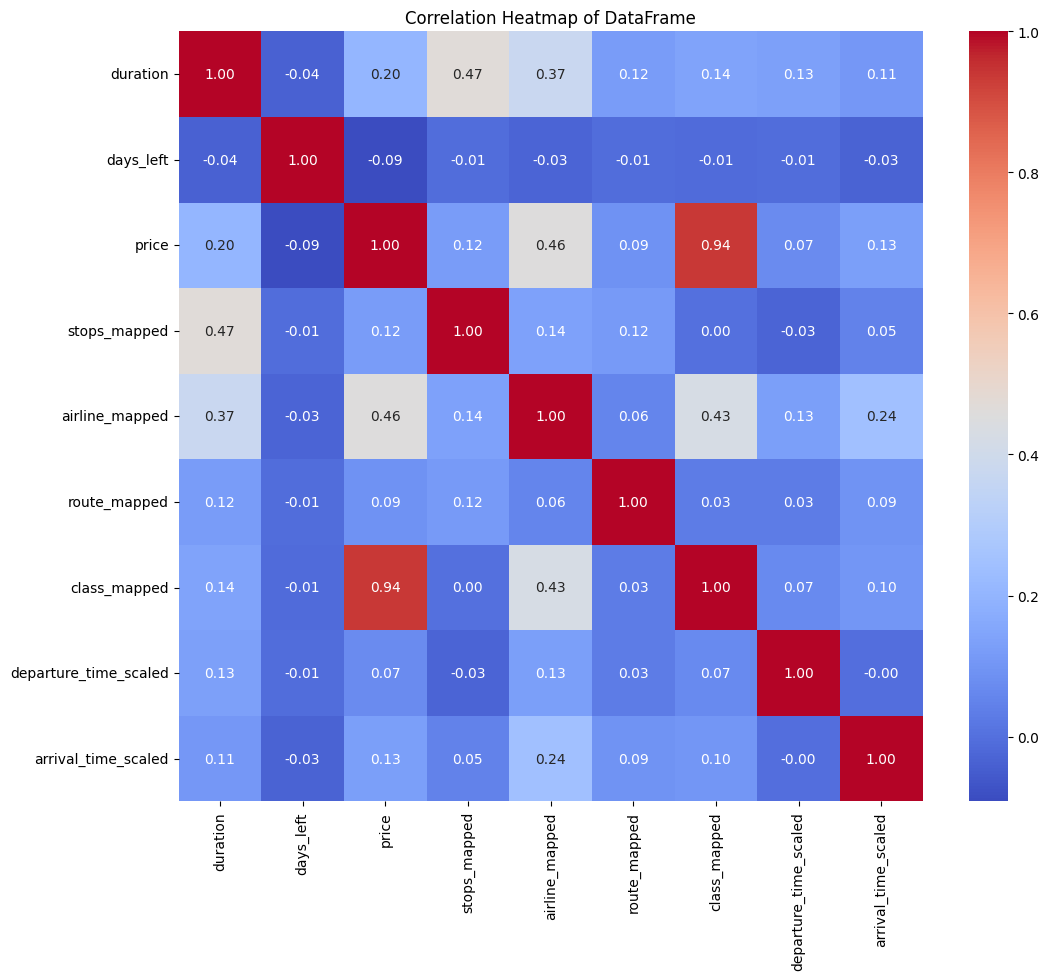

In [24]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame')
plt.show()

In [25]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
x_train = train_df.drop('price', axis=1).values
y_train = train_df['price'].values

x_test = test_df.drop('price', axis=1).values
y_test = test_df['price'].values

In [27]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Random Forest Model

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished


RandomForestRegressor(max_depth=25, min_samples_split=4, n_estimators=500,
                      n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    3.0s finished


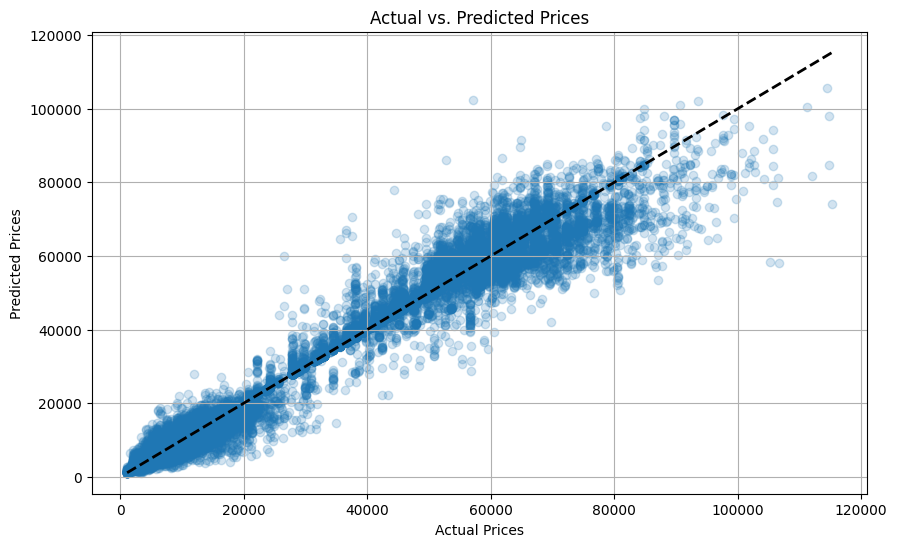

In [32]:
rf_predictions = rf_model.predict(x_test_scaled)

plot_predictions(y_test, rf_predictions)

In [34]:
r2_score(y_test, rf_predictions)

0.9854068676654707

In [35]:
mean_absolute_error(y_test, rf_predictions)

np.float64(1122.9828843711095)

# XGBoost Model

In [36]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=25,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # Stop if validation score doesn't improve
)

xgb_model.fit(x_train_scaled, y_train, eval_set=[(x_test_scaled, y_test)], verbose=True)

[0]	validation_0-rmse:21602.41392
[1]	validation_0-rmse:20556.84997
[2]	validation_0-rmse:19564.51679
[3]	validation_0-rmse:18622.87275
[4]	validation_0-rmse:17728.91582
[5]	validation_0-rmse:16880.74021
[6]	validation_0-rmse:16075.64795
[7]	validation_0-rmse:15311.44061
[8]	validation_0-rmse:14586.18546
[9]	validation_0-rmse:13897.32945
[10]	validation_0-rmse:13244.59340
[11]	validation_0-rmse:12625.67893
[12]	validation_0-rmse:12039.26326
[13]	validation_0-rmse:11482.41786
[14]	validation_0-rmse:10954.21571
[15]	validation_0-rmse:10453.88681
[16]	validation_0-rmse:9979.99559
[17]	validation_0-rmse:9530.50121
[18]	validation_0-rmse:9106.40149
[19]	validation_0-rmse:8704.63510
[20]	validation_0-rmse:8324.51841
[21]	validation_0-rmse:7965.08096
[22]	validation_0-rmse:7625.63104
[23]	validation_0-rmse:7304.94021
[24]	validation_0-rmse:7002.50759
[25]	validation_0-rmse:6717.13366
[26]	validation_0-rmse:6448.45360
[27]	validation_0-rmse:6195.36522
[28]	validation_0-rmse:5955.11356
[29]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=25,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

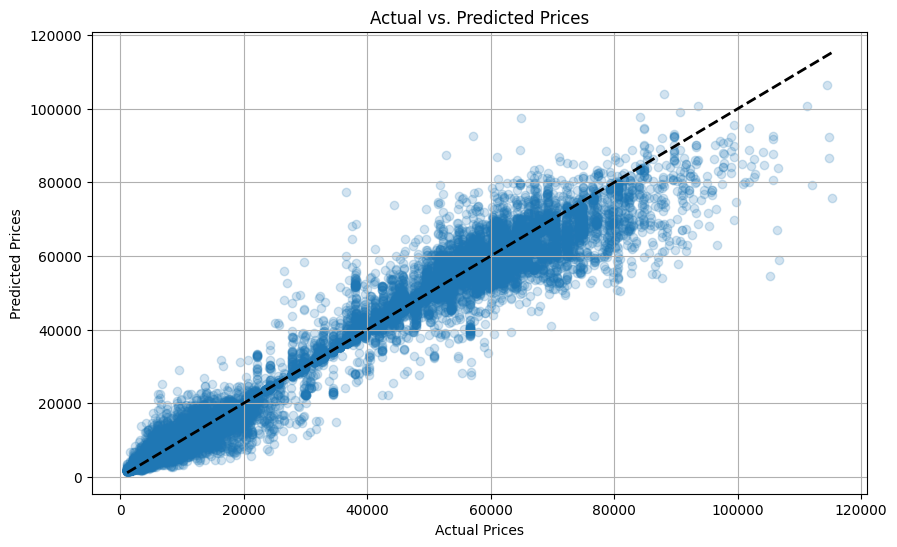

In [37]:
xgb_predictions = xgb_model.predict(x_test_scaled)

plot_predictions(y_test, xgb_predictions)

In [38]:
mean_absolute_error(y_test, xgb_predictions)

np.float64(1205.3962186939905)

In [39]:
r2_score(y_test, xgb_predictions)

0.9848850965499878

# LightGBM Model

In [120]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=4000,
    learning_rate=0.02,
    num_leaves=255, # Controls the complexity of the tree
    random_state=42,
    min_child_samples=20,
    n_jobs=-1,
    verbose=-1 # Suppress verbose output
)

# Use a callback for early stopping
lgb_model.fit(x_train_scaled, y_train,
              eval_set=[(x_test_scaled, y_test)],
              eval_metric='l1', # l1 is MAE
              callbacks=[lgb.early_stopping(50)])

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[4000]	valid_0's l1: 1240.18	valid_0's l2: 6.61007e+06


LGBMRegressor(learning_rate=0.02, n_estimators=4000, n_jobs=-1, num_leaves=255,
              random_state=42, verbose=-1)

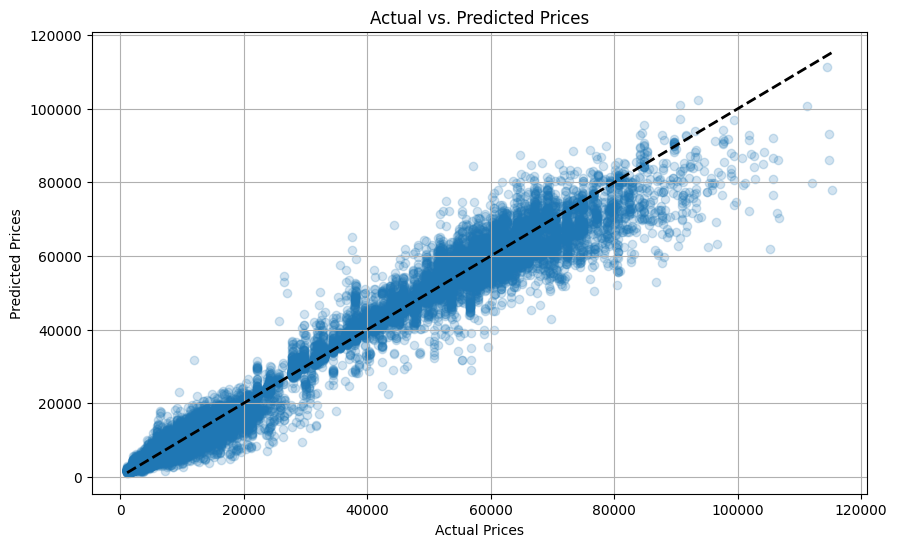

In [121]:
lgb_predictions = lgb_model.predict(x_test_scaled)

plot_predictions(y_test, lgb_predictions)

In [122]:
r2_score(y_test, lgb_predictions)

0.987176916766969

In [123]:
300000/160

1875.0

# CAT Model

In [ ]:
cat_model = cb.CatBoostRegressor(
    iterations=4000,           # Equivalent to n_estimators
    learning_rate=0.05,
    depth=6,                   # Equivalent to max_depth
    random_state=42,
    verbose=1,                 # Suppress verbose output
    early_stopping_rounds=50,
    allow_writing_files=False    # Prevents CatBoost from creating log files
)

cat_model.fit(x_train_scaled, y_train, eval_set=(x_test_scaled, y_test))

0:	learn: 21637.1692640	test: 21644.1395508	best: 21644.1395508 (0)	total: 18.3ms	remaining: 1m 13s
1:	learn: 20630.4240164	test: 20636.5176657	best: 20636.5176657 (1)	total: 36.6ms	remaining: 1m 13s
2:	learn: 19687.6072706	test: 19693.3332158	best: 19693.3332158 (2)	total: 62.9ms	remaining: 1m 23s
3:	learn: 18787.2428697	test: 18792.4775829	best: 18792.4775829 (3)	total: 86.2ms	remaining: 1m 26s
4:	learn: 17931.3359574	test: 17936.4011903	best: 17936.4011903 (4)	total: 110ms	remaining: 1m 28s
5:	learn: 17120.9701171	test: 17125.7677878	best: 17125.7677878 (5)	total: 134ms	remaining: 1m 29s
6:	learn: 16361.7025088	test: 16366.7114896	best: 16366.7114896 (6)	total: 160ms	remaining: 1m 31s
7:	learn: 15638.9596376	test: 15644.1527771	best: 15644.1527771 (7)	total: 186ms	remaining: 1m 32s
8:	learn: 14955.8985645	test: 14961.5593911	best: 14961.5593911 (8)	total: 206ms	remaining: 1m 31s
9:	learn: 14313.1344944	test: 14319.2317682	best: 14319.2317682 (9)	total: 230ms	remaining: 1m 31s
10:	le

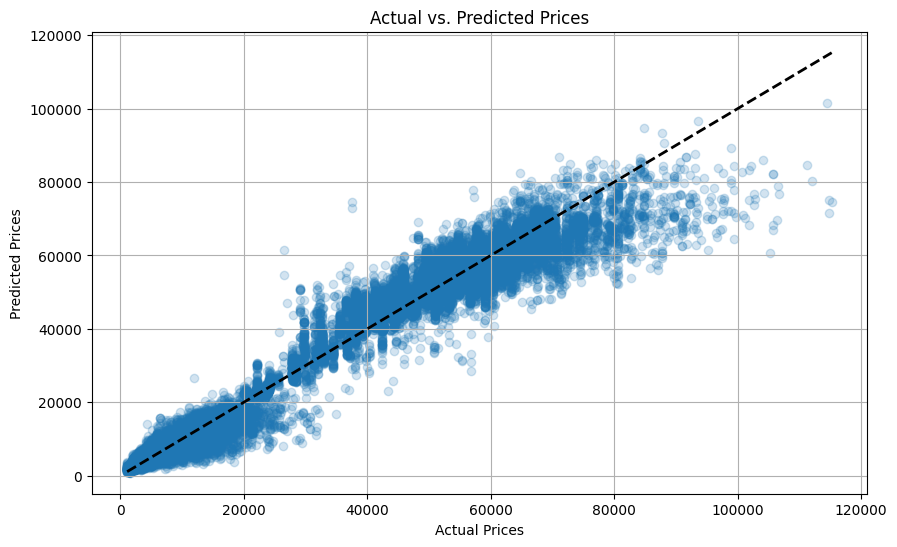

In [131]:
cb_predictions = cat_model.predict(x_test_scaled)

plot_predictions(y_test, cb_predictions)

In [132]:
r2_score(y_test, cb_predictions)

0.9784266742646726